In [1]:
import multiprocessing
import time
from ray.tune.registry import register_env
from pycigar.utils.registry import make_create_env
from pycigar.utils.input_parser import input_parser
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from pycigar.utils.logging import logger
import os
import pycigar

PATH = os.getcwd()


#file_name = '/tmp/lbnl/delete_me/half_full_40_1/run_train/run_train_1_lr=0.001_2020-06-15_02-47-57ak0kvjv5/best/policy_70'#'half_full__sim35_jun_1/full_train_1/run_train/run_train_1_lr=0.001_2020-06-02_04-24-28fbkv0xnf/best/policy'#'policy'
#file_name = '/home/toanngo/Pictures/delete_me_frame_6/half_full_40_1/run_train/run_train_0_lr=0.001_2020-06-16_19-51-18bvdh60uo/best/policy_140'
#file_name = '/home/toanngo/Pictures/delete_me_frame_6/half_full_40_0/run_train/run_train_1_lr=0.001_2020-06-16_17-51-00fejko8f_/best/policy_70'
#file_name = '/home/toanngo/Videos/sbar_eval_15_18_100_y_3/main/run_train/run_train_0_lr=0.001_2020-06-25_02-54-164assg8ul/best/policy_200'
#file_name = '/home/toanngo/Videos/sbar_eval_filter_triple/main/run_train/run_train_1_lr=0.001_2020-06-26_09-03-184puqsy4u/best/policy_240'
#file_name = '/home/toanngo/Videos/sbar_eval_filter_triple_8frame_OK/main/run_train/run_train_0_lr=0.001_2020-06-27_20-49-39zy08f58y/best/policy_300'
file_name = '/home/toanngo/Documents/policy_240'
policy = os.path.join(PATH, file_name) 
start = 11000
percentage_hack = 0.45

"""
Load the scenarios configuration file. This file contains the scenario information
for the experiment.
"""
misc_inputs_path = pycigar.DATA_DIR + "/ieee37busdata/misc_inputs.csv"
dss_path = pycigar.DATA_DIR + "/ieee37busdata/ieee37.dss"
load_solar_path = pycigar.DATA_DIR + "/ieee37busdata/load_solar_data.csv"
breakpoints_path = pycigar.DATA_DIR + "/ieee37busdata/breakpoints.csv"

sim_params = input_parser(misc_inputs_path, dss_path, load_solar_path, breakpoints_path, benchmark=True, percentage_hack=percentage_hack)
pycigar_params = {"exp_tag": "cooperative_multiagent_ppo",
                    "env_name": "CentralControlPVInverterEnv",
                    "simulator": "opendss"}

create_env, env_name = make_create_env(pycigar_params, version=0)
register_env(env_name, create_env)
sim_params['scenario_config']['start_end_time'] = [start, start + 750]
del sim_params['attack_randomization']
test_env = create_env(sim_params)
test_env.observation_space  # get the observation space, we need this to construct our agent(s) observation input
test_env.action_space  # get the action space, we need this to construct our agent(s) action output
tf.compat.v1.enable_eager_execution()
policy = tf.saved_model.load(policy)
infer = policy.signatures['serving_default']
done = False
obs = test_env.reset()
obs = obs.tolist()
t = 0
while not done:
    t += 1
    act_logits = infer(
        prev_reward=tf.constant([0.], tf.float32),
        observations=tf.constant([obs], tf.float32),
        is_training=tf.constant(False),
        seq_lens=tf.constant([0], tf.int32),
        prev_action=tf.constant([0], tf.int64)
    )['behaviour_logits'].numpy()
    act = np.argmax(act_logits)

    if t > 15:
        act = 3
    obs, r, done, _ = test_env.step(act)
    obs = obs.tolist()
log_dict = logger().log_dict
custom_metrics = logger().custom_metrics

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


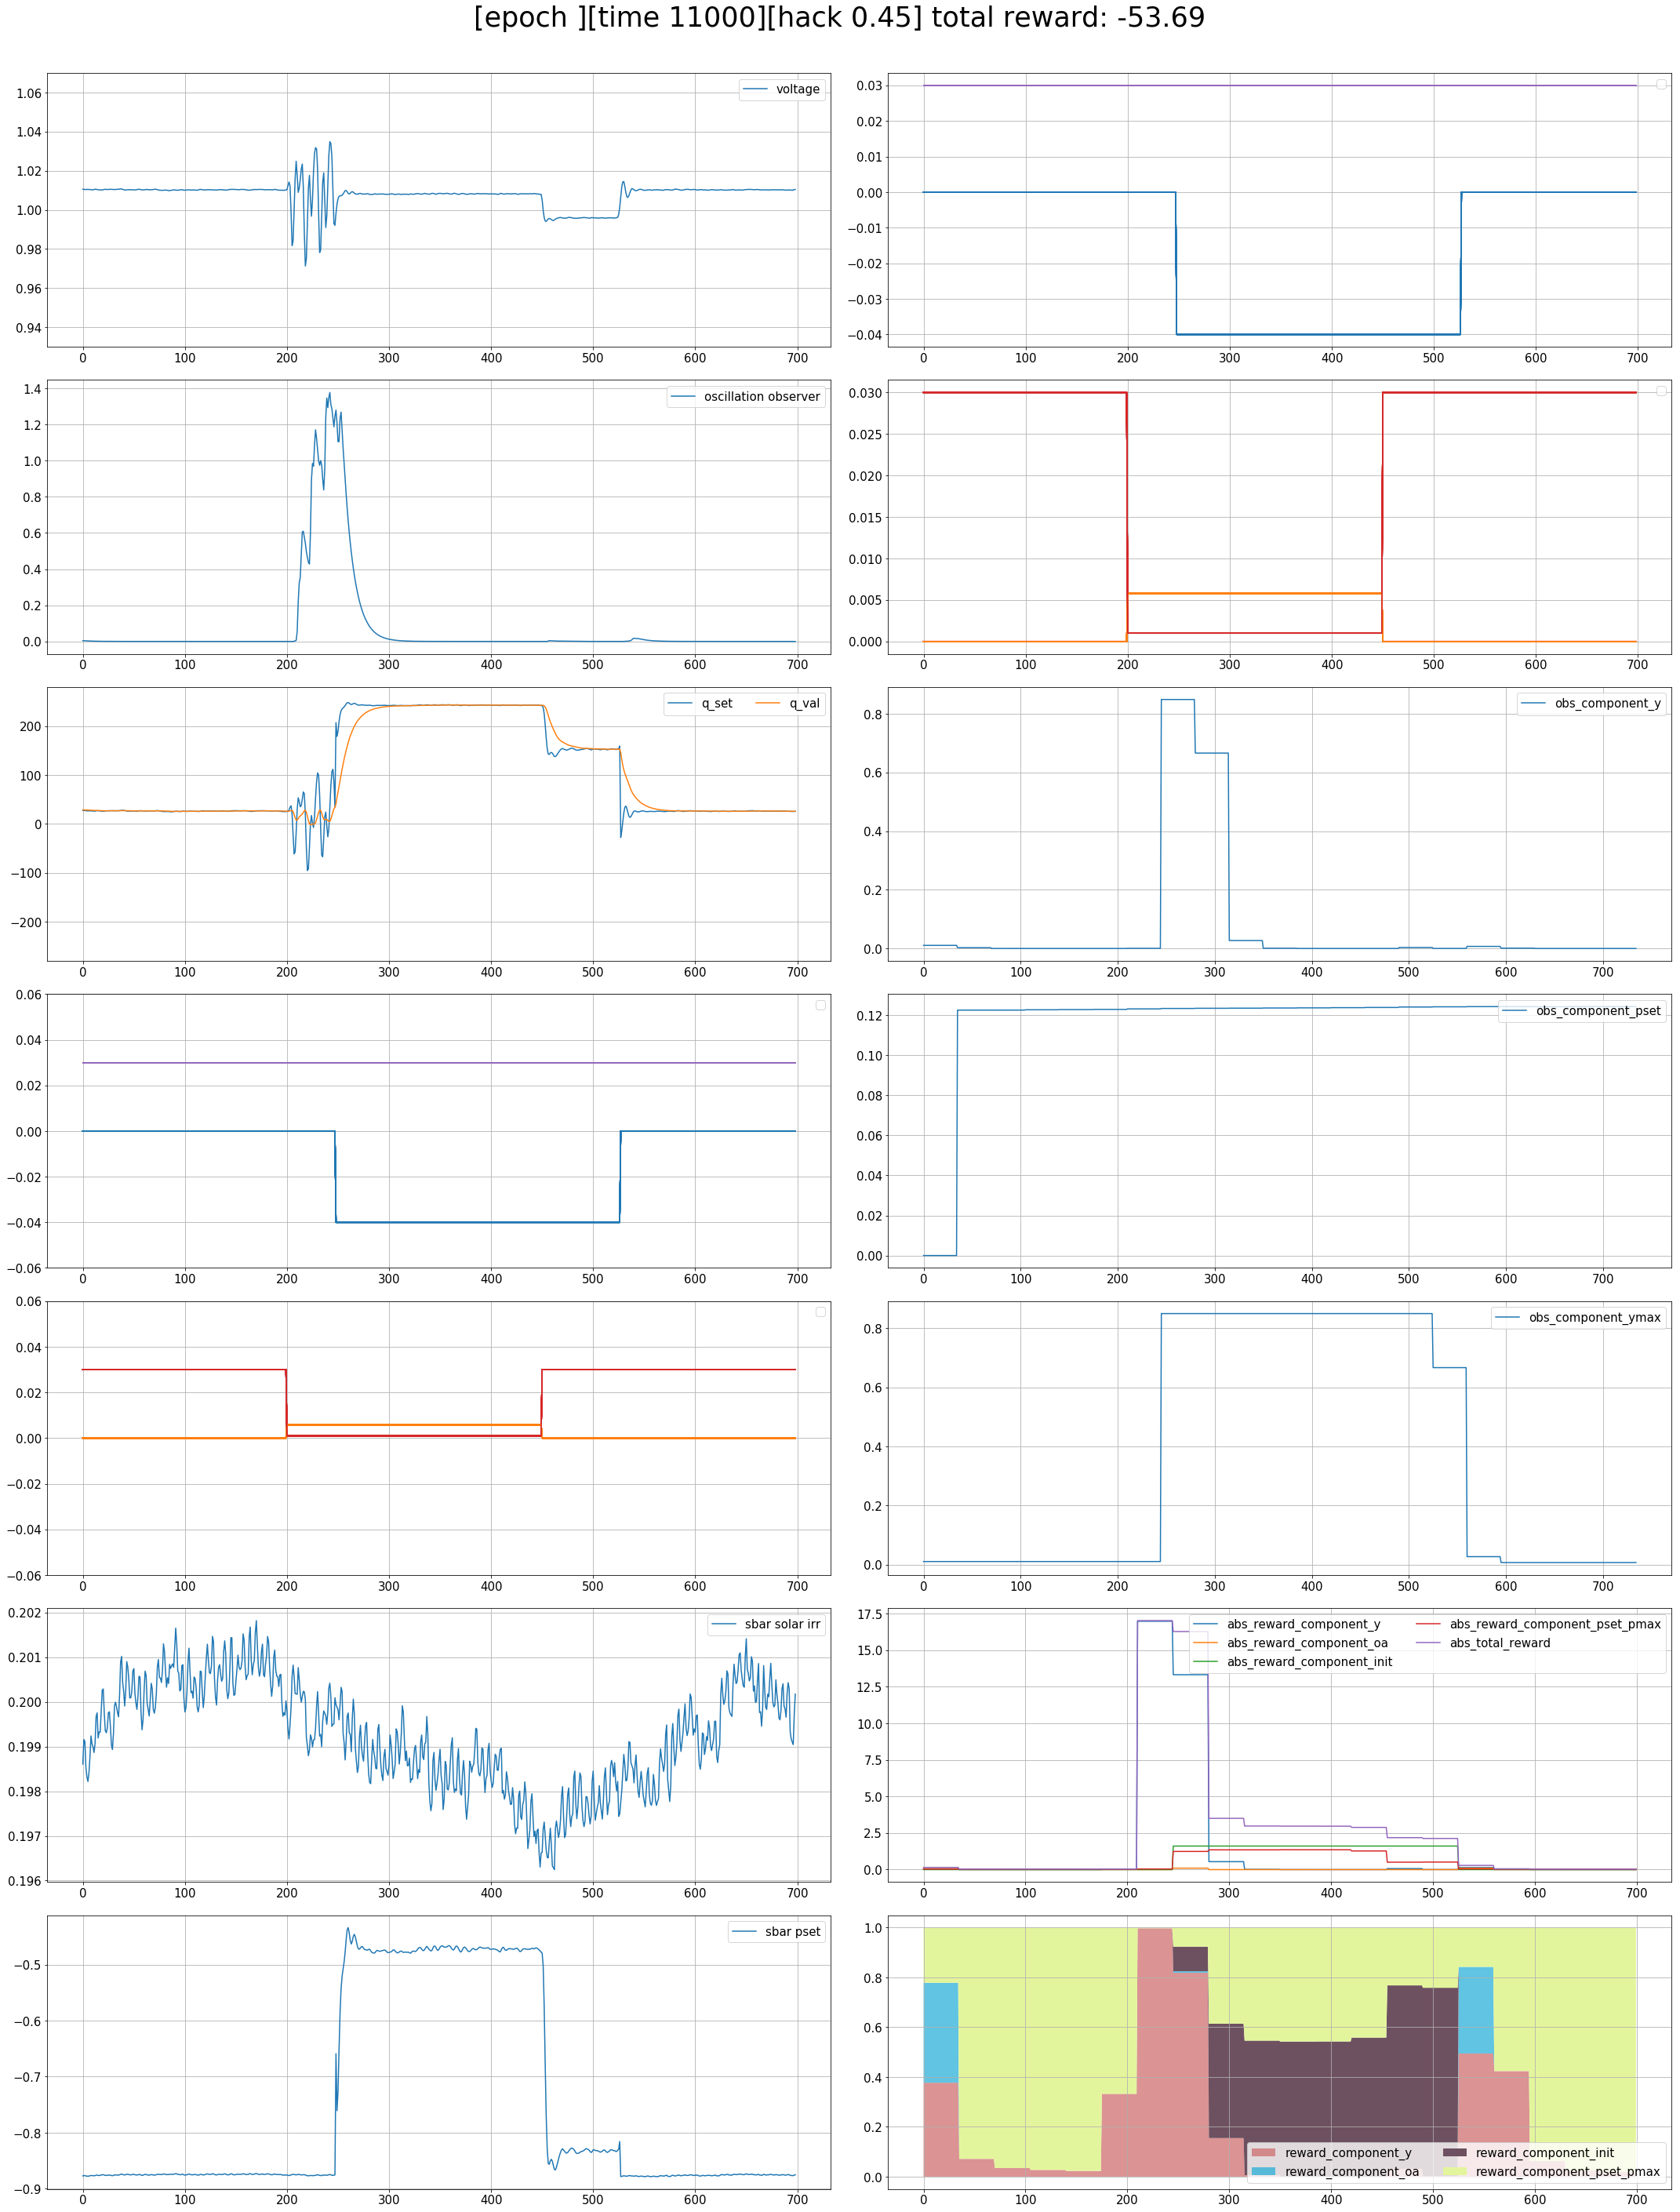

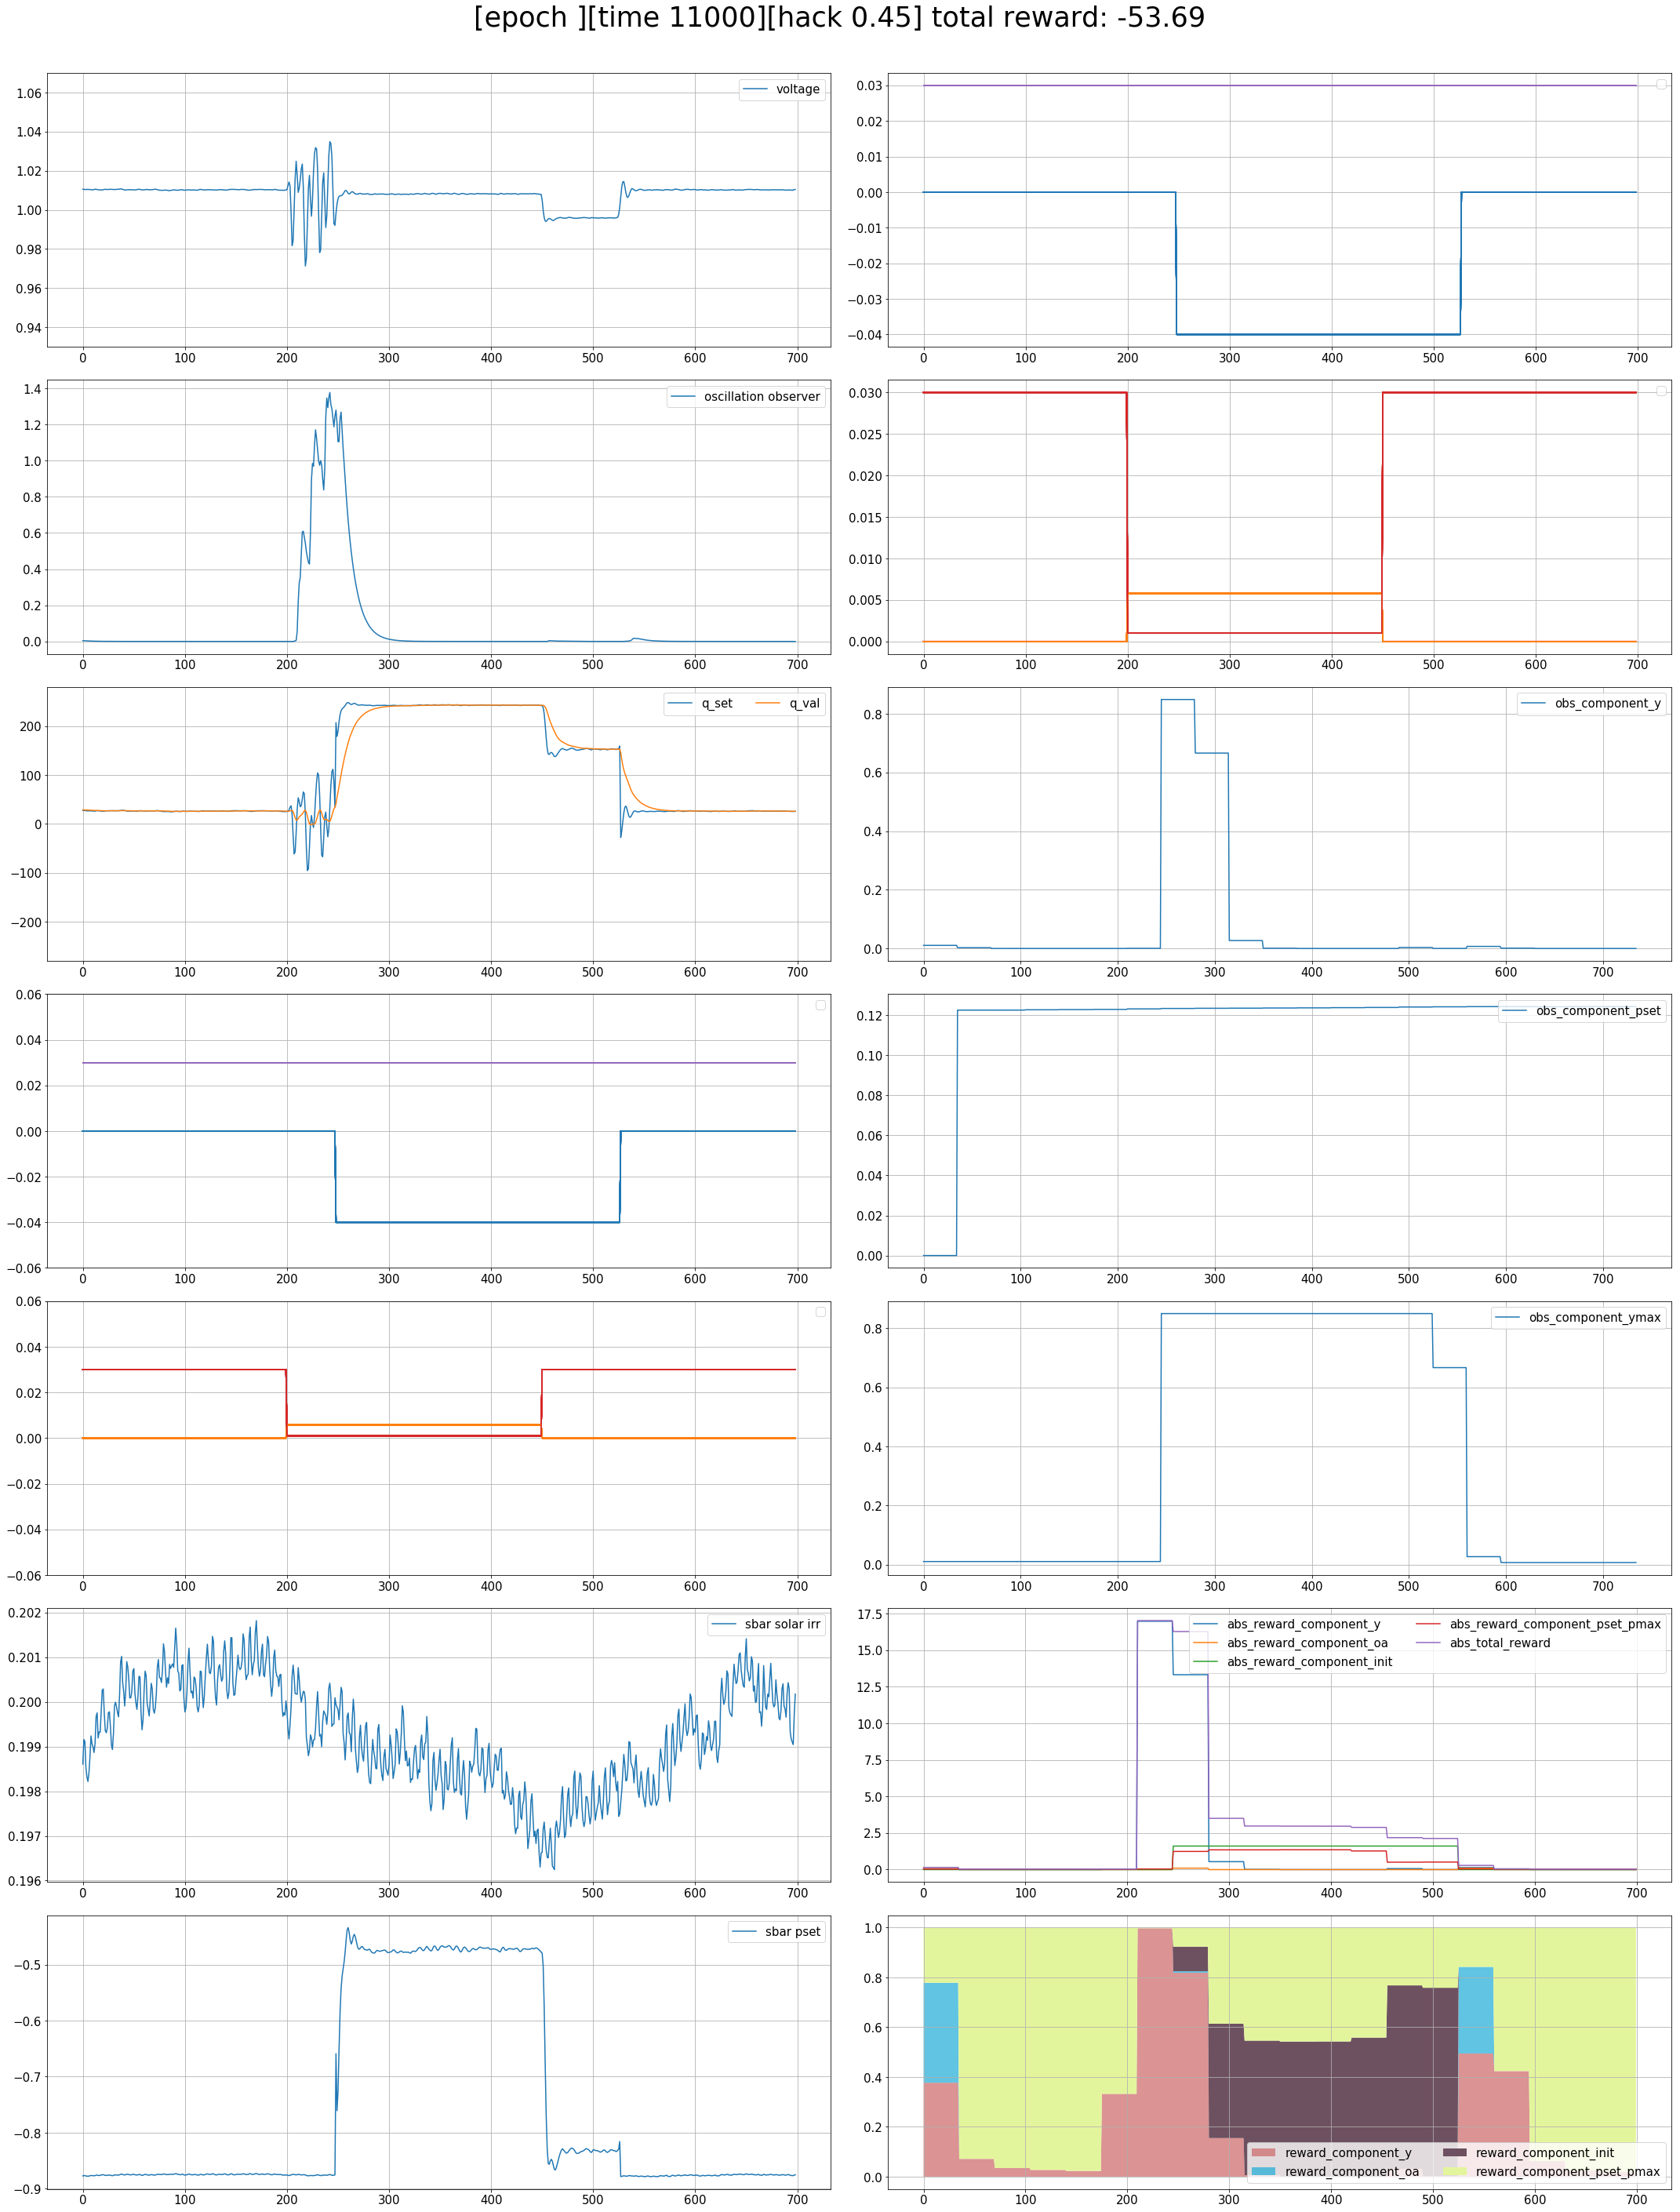

In [2]:
from pycigar.utils.output import plot_new
plot_new(log_dict, custom_metrics)

In [3]:
def get_translation_and_slope(a_val):
    points = np.array(a_val)
    slope = points[:, 1] - points[:, 0]
    og_point = points[0, 2]
    translation = points[:, 2] - og_point
    return translation, slope

In [4]:
result = {}
result['v'] = []
result['y'] = []
result['translation'] = []
result['slope'] = []
result['translation_adv'] = []
result['slope_adv'] = []
result['component_y'] = []
result['component_oa'] = []
result['component_init'] = []
result['component_pset_pmax'] = []
result['total_reward'] = []

node = 's701a'
translation, slope = get_translation_and_slope(log_dict['inverter_' + node]['control_setting'])
translation_adv, slope_adv = get_translation_and_slope(log_dict['adversary_inverter_' + node]['control_setting'])
component_y = np.array(log_dict['component_reward']['component_y'])
component_oa = np.array(log_dict['component_reward']['component_oa'])
component_init = np.array(log_dict['component_reward']['component_init'])
component_pset_pmax = np.array(log_dict['component_reward']['component_pset_pmax'])
total_reward = component_y + component_oa + component_init + component_pset_pmax

for i in range(len(log_dict[node]['voltage'])):
    result['v'].append(log_dict[node]['voltage'][i])
    result['y'].append(log_dict['inverter_' + node]['y'][i])
    result['translation'].append(translation[i])
    result['slope'].append(slope[i])
    result['translation_adv'].append(translation_adv[i])
    result['slope_adv'].append(slope_adv[i])

    result['component_y'].append(component_y[i])
    result['component_oa'].append(component_oa[i])
    result['component_init'].append(component_init[i])
    result['component_pset_pmax'].append(component_pset_pmax[i])
    result['total_reward'].append(total_reward[i])

In [5]:
import pandas as pd

df = pd.DataFrame.from_dict(result)
#df.to_csv("eval_hist_{}_{}_new_new_filter_solar_randomization_8f.csv".format(start, percentage_hack))
df.to_csv("eval_hist_{}_{}_new_new_filter_solar_randomization_8f.csv".format('no', 'act'))

In [5]:
import pandas as pd
df = pd.read_csv('progress.csv')

In [11]:
result = {}
result['mean'] = []
result['std'] = []

for i in range(len(df)):
    result['mean'].append(df['episode_reward_mean'][i])
    result['std'].append(0)

df = pd.DataFrame.from_dict(result)
df.to_csv("reward_convergence.csv")

In [10]:
df['episode_reward_mean'][2]

-399.4700310652173

In [6]:
import os
directory =  '/home/toanngo/Videos/sbar_eval_filter_triple_8frame_OK/'#'/home/toanngo/Videos/sbar_eval_filter_double/' #'/home/toanngo/Pictures/delete_me_frame_6/' #'/tmp/lbnl/' #os.path.join(PATH, 'half_full__sim35_jun_1')  #'/tmp/lbnl/full_eval_1616_lr2_20_256'
folders = [f for f in os.listdir(directory) if '.pickle' not in f]

In [7]:
def fileCount(path, extension):
    count = []
    for root, dirs, files in os.walk(path):
        for f in files:
            if f.endswith(extension):
                count.append([root, dirs, f])
    return count

In [8]:
a = fileCount(directory, '.csv')

In [9]:
a

[['/home/toanngo/Videos/sbar_eval_filter_triple_8frame_OK/main/run_train/run_train_1_lr=0.001_2020-06-27_20-49-3984amvdia',
  ['checkpoint', 'best', 'latest'],
  'progress.csv'],
 ['/home/toanngo/Videos/sbar_eval_filter_triple_8frame_OK/main/run_train/run_train_2_lr=0.001_2020-06-27_23-31-35c8esxivm',
  ['checkpoint', 'best', 'latest'],
  'progress.csv'],
 ['/home/toanngo/Videos/sbar_eval_filter_triple_8frame_OK/main/run_train/run_train_1_lr=0.001_2020-06-27_23-31-35331quvfq',
  ['checkpoint', 'best', 'latest'],
  'progress.csv'],
 ['/home/toanngo/Videos/sbar_eval_filter_triple_8frame_OK/main/run_train/run_train_0_lr=0.001_2020-06-27_15-25-10e38iq8my',
  ['checkpoint', 'best', 'latest'],
  'progress.csv'],
 ['/home/toanngo/Videos/sbar_eval_filter_triple_8frame_OK/main/run_train/run_train_0_lr=0.001_2020-06-27_23-31-35cn5un1t4',
  ['checkpoint', 'best', 'latest'],
  'progress.csv'],
 ['/home/toanngo/Videos/sbar_eval_filter_triple_8frame_OK/main/run_train/run_train_2_lr=0.001_2020-06-27_

In [10]:
import pandas as pd
result = {}
for i, d in enumerate(a):
    ds = d[0] + '/' + d[2]
    df = pd.read_csv(ds)
    result[i] = df['episode_reward_mean']

In [11]:
df = pd.DataFrame.from_dict(result)

In [12]:
df

0           1           2           3           4           5   \
0   -182.493034 -145.317221 -153.731835 -147.749506 -137.301053 -171.896641   
1   -155.883660 -144.685232 -147.293961 -150.539282 -126.468810 -148.147604   
2   -152.284329 -139.568781 -137.272130 -146.945234 -124.448720 -136.985461   
3   -145.615079 -133.792347 -139.072724 -143.638724 -124.618378 -132.824615   
4   -134.772143 -131.673808 -131.511075 -138.596583 -122.350005 -129.574363   
..          ...         ...         ...         ...         ...         ...   
295  -54.673246         NaN         NaN  -50.418557         NaN  -60.155394   
296  -57.141649         NaN         NaN  -48.167090         NaN  -58.881321   
297  -56.936679         NaN         NaN  -50.256994         NaN  -60.075754   
298  -56.481302         NaN         NaN  -51.279272         NaN  -57.432397   
299  -54.785758         NaN         NaN  -52.481131         NaN  -53.903435   

             6           7           8           9           10          11  
0   -160.088228 -142.287338 -129.627839 -161.556308 -125.707994 -165.287616  
1   -143.970801 -135.565877 -133.349792 -147.191977 -128.616090 -145.496424  
2   -143.669037 -129.415612 -134.970289 -141.670623 -132.541395 -139.797866  
3   -136.827987 -127.445103 -128.677779 -137.550417 -128.509644 -136.298920  
4   -128.040295 -121.232148 -127.904699 -129.493699 -125.327234 -133.770964  
..          ...         ...         ...         ...         ...         ...  
295  -57.020630  -58.040680  -53.479213  -55.059926  -53.699944  -54.576911  
296  -56.304200  -55.187953  -55.173869  -57.779813  -52.489355  -56.703423  
297  -57.390309  -54.040783  -53.867955  -59.056453  -53.882702  -54.426612  
298  -54.984218  -51.555041  -55.241826  -58.503949  -53.531803  -54.700525  
299  -54.682674  -53.263525  -53.901407  -57.654961  -54.241485  -55.322983  

[300 rows x 12 columns]

In [13]:
import numpy as np
list(df.dropna(axis=1).mean(axis=1))
#list(df[0:70].dropna(axis=1).std(axis=1))

[-154.0771671091055,
 -143.19572314116462,
 -139.8088717918952,
 -135.26536305381418,
 -129.85690308960622,
 -123.0666132459026,
 -117.24935179890427,
 -112.23245857560737,
 -109.8937176556708,
 -106.4129391051084,
 -102.77500954220798,
 -101.38650697756064,
 -98.38208093027862,
 -94.77494039205287,
 -93.12142200651529,
 -91.63709541448392,
 -90.3818700653024,
 -88.05153715933562,
 -88.22220267036313,
 -86.97062775536067,
 -85.58712722673197,
 -83.85406474262066,
 -83.74897426780554,
 -81.3936685421408,
 -80.6381634064909,
 -79.95533537506827,
 -78.59934642405352,
 -76.8486991683755,
 -76.53054989454758,
 -75.72816590067697,
 -74.89507455249435,
 -72.36341639260752,
 -70.88882137932468,
 -70.02361428264625,
 -69.12354326628702,
 -69.26853332127149,
 -69.91111730925252,
 -69.75364479256736,
 -70.23950510166392,
 -70.1682811186077,
 -68.91257235396976,
 -67.61144600576802,
 -66.15949441815023,
 -64.6802226360738,
 -64.53468694932434,
 -64.745516263907,
 -65.91080702214937,
 -66.458083179

In [14]:
result_all = {}
result_all['mean'] = []
result_all['std'] = []

result_all['mean'] = list(df.dropna(axis=1).mean(axis=1))
result_all['std'] = list(df.dropna(axis=1).std(axis=1))

df = pd.DataFrame.from_dict(result_all)
df.to_csv("reward_convergence_new_new_filter_solar_randomization_8f.csv")

In [5]:
import multiprocessing
import time
from ray.tune.registry import register_env
from pycigar.utils.registry import make_create_env
from pycigar.utils.input_parser import input_parser
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from pycigar.utils.logging import logger
import os
import pycigar

PATH = os.getcwd()


file_name = 'policy'
policy = os.path.join(PATH, file_name) 
start = 11000
percentage_hack = 0.45

"""
Load the scenarios configuration file. This file contains the scenario information
for the experiment.
"""
misc_inputs_path = pycigar.DATA_DIR + "/ieee37busdata/misc_inputs.csv"
dss_path = pycigar.DATA_DIR + "/ieee37busdata/ieee37.dss"
load_solar_path = pycigar.DATA_DIR + "/ieee37busdata/load_solar_data.csv"
breakpoints_path = pycigar.DATA_DIR + "/ieee37busdata/breakpoints.csv"

sim_params = input_parser(misc_inputs_path, dss_path, load_solar_path, breakpoints_path, benchmark=True, percentage_hack=percentage_hack)
pycigar_params = {"exp_tag": "cooperative_multiagent_ppo",
                    "env_name": "CentralControlPVInverterEnv",
                    "simulator": "opendss"}

create_env, env_name = make_create_env(pycigar_params, version=0)
register_env(env_name, create_env)
sim_params['scenario_config']['start_end_time'] = [start, start + 750]
del sim_params['attack_randomization']
test_env = create_env(sim_params)
test_env.observation_space  # get the observation space, we need this to construct our agent(s) observation input
test_env.action_space  # get the action space, we need this to construct our agent(s) action output
done = False
obs = test_env.reset()
obs = obs.tolist()
act = 0
while not done:
    #act = 2
    obs, r, done, _ = test_env.step(act)
    if act < 12:
        act += 1
    obs = obs.tolist()
log_dict = logger().log_dict
custom_metrics = logger().custom_metrics

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


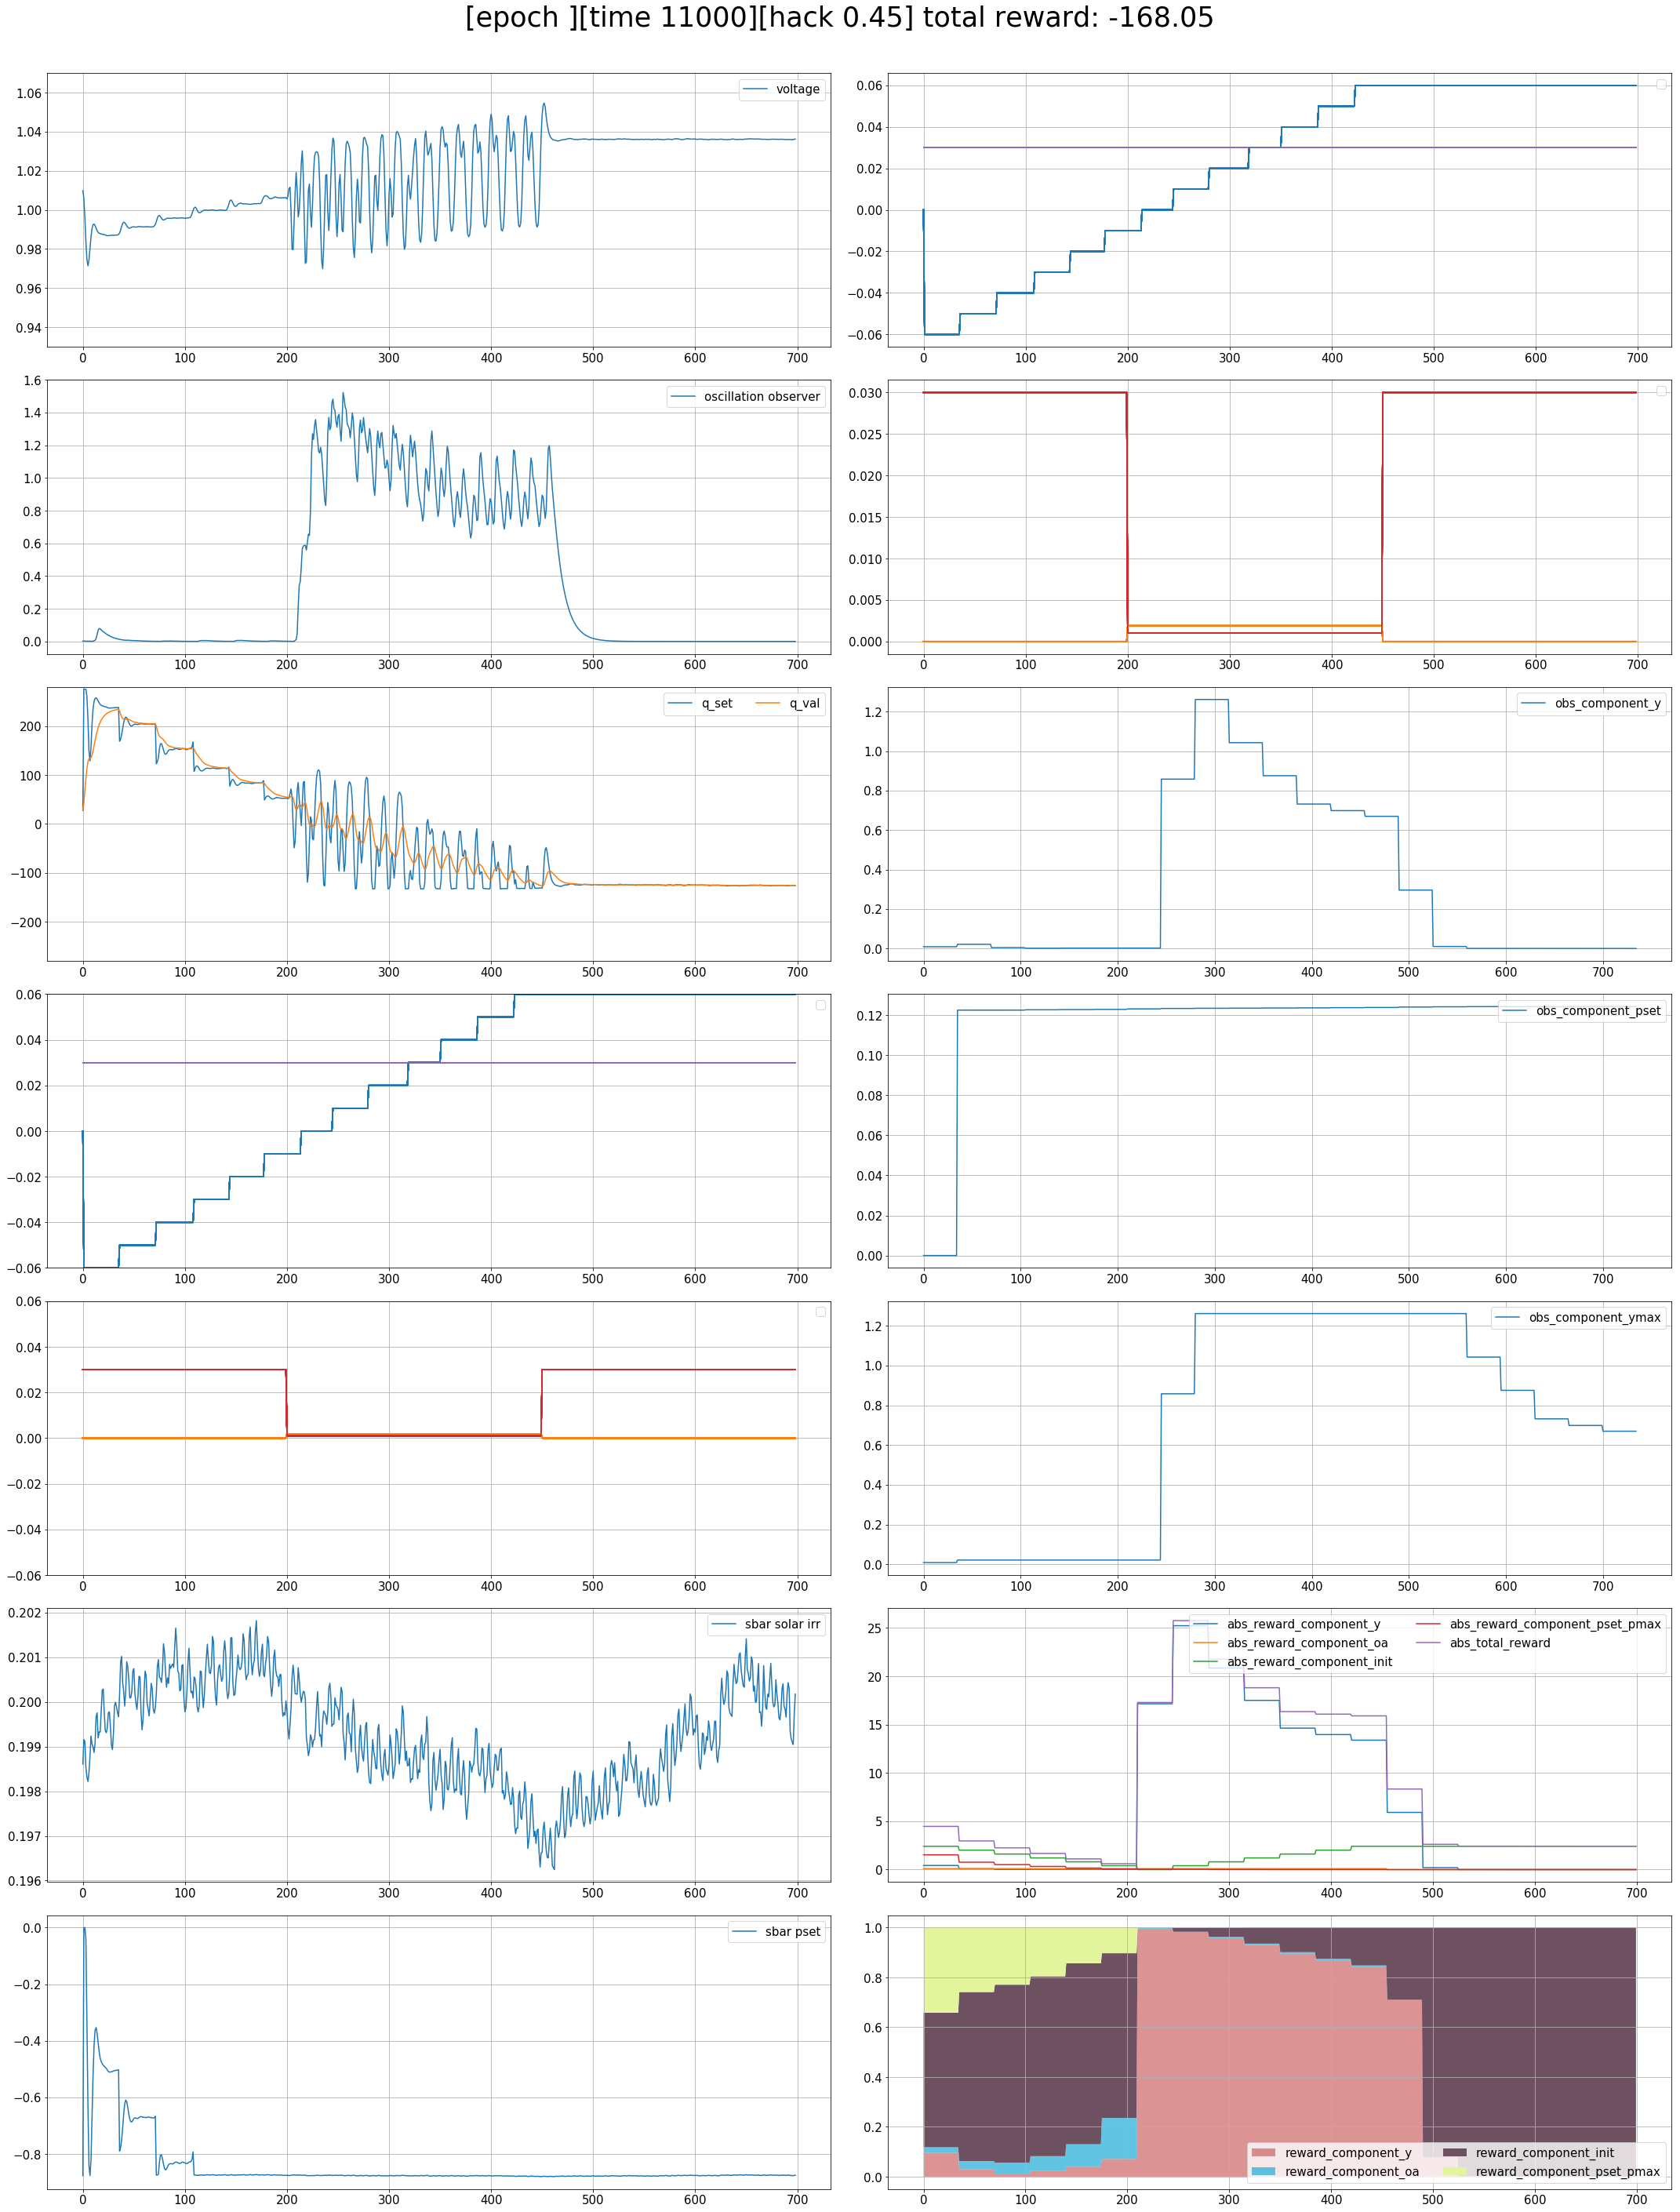

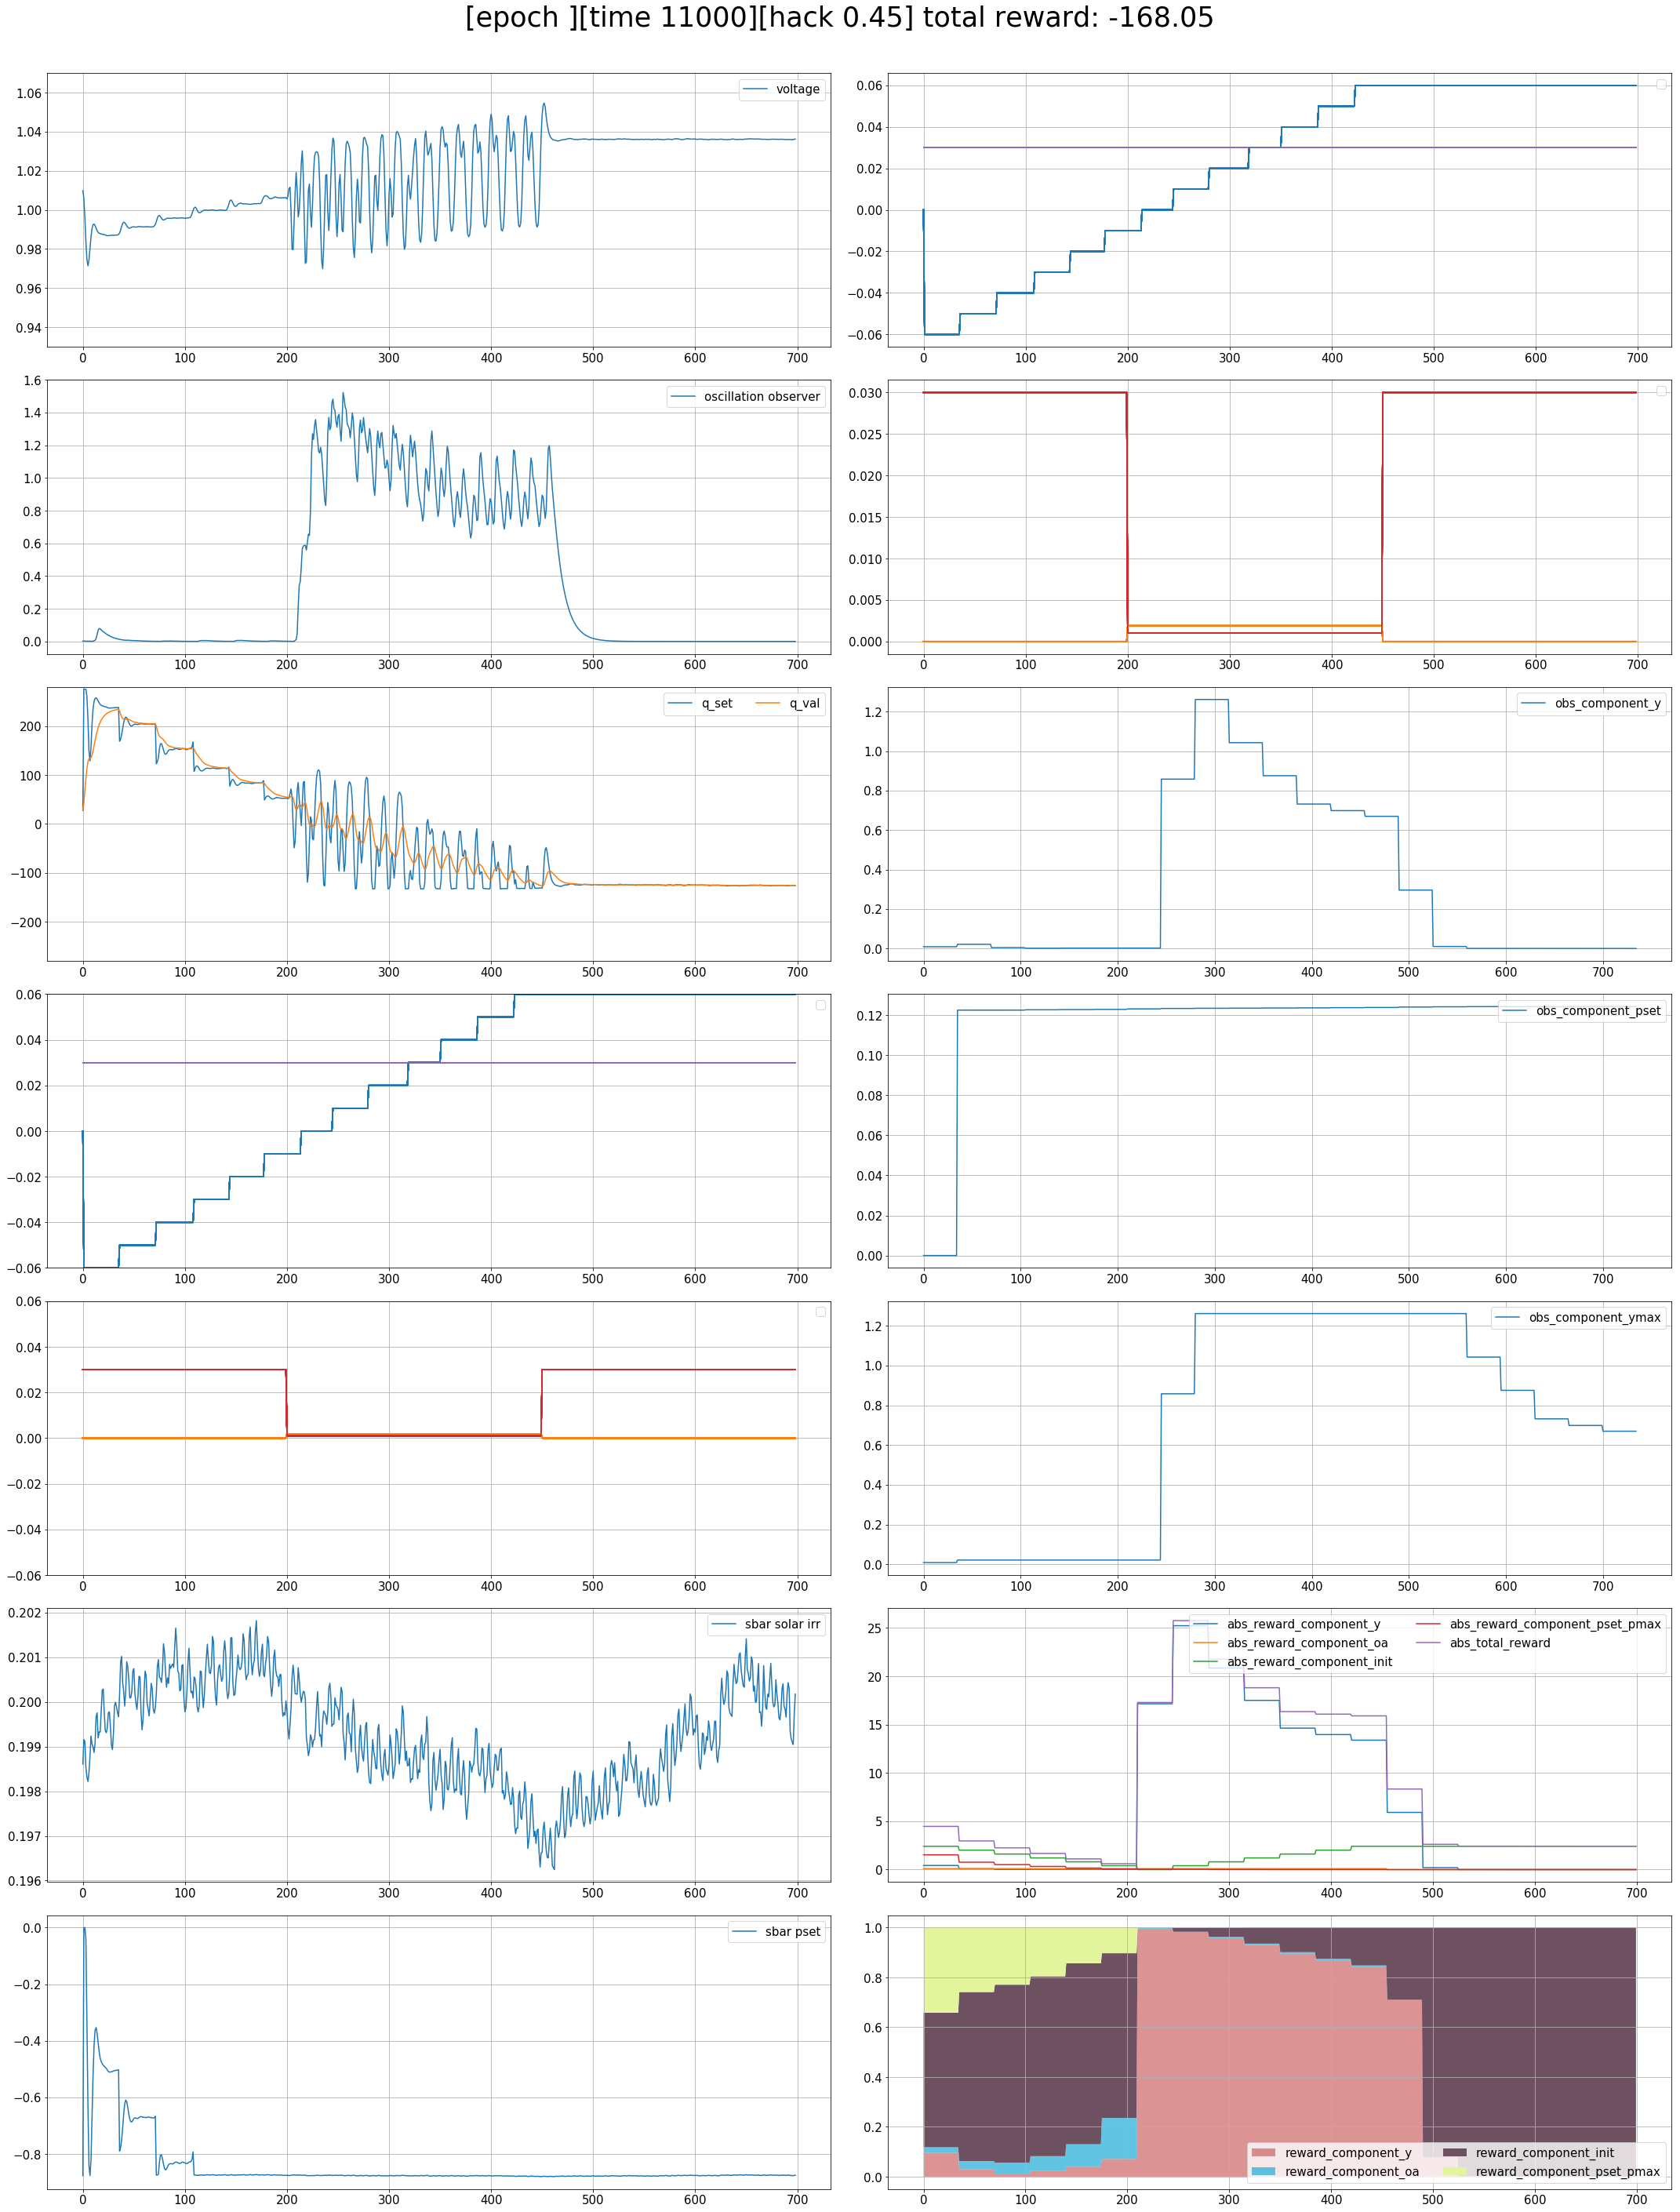

In [6]:
from pycigar.utils.output import plot_new
plot_new(log_dict, custom_metrics)

In [1]:
import multiprocessing
import time
from ray.tune.registry import register_env
from pycigar.utils.registry import make_create_env
from pycigar.utils.input_parser import input_parser
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from pycigar.utils.logging import logger
import os
import pycigar

start = 11000
percentage_hack = 0.45

"""
Load the scenarios configuration file. This file contains the scenario information
for the experiment.
"""
misc_inputs_path = pycigar.DATA_DIR + "/ieee37busdata/misc_inputs.csv"
dss_path = pycigar.DATA_DIR + "/ieee37busdata/ieee37.dss"
load_solar_path = pycigar.DATA_DIR + "/ieee37busdata/load_solar_data.csv"
breakpoints_path = pycigar.DATA_DIR + "/ieee37busdata/breakpoints.csv"

sim_params = input_parser(misc_inputs_path, dss_path, load_solar_path, breakpoints_path, benchmark=True, percentage_hack=percentage_hack)
pycigar_params = {"exp_tag": "cooperative_multiagent_ppo",
                    "env_name": "CentralControlPVInverterEnv",
                    "simulator": "opendss"}

create_env, env_name = make_create_env(pycigar_params, version=0)
register_env(env_name, create_env)
sim_params['scenario_config']['start_end_time'] = [start, start + 750]
del sim_params['attack_randomization']
test_env = create_env(sim_params)
test_env.observation_space  # get the observation space, we need this to construct our agent(s) observation input
test_env.action_space  # get the action space, we need this to construct our agent(s) action output
done = False
obs = test_env.reset()
obs = obs.tolist()

obs, r, done, _ = test_env.step(2)
obs = obs.tolist()